<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749 entries, 0 to 3748
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3749 non-null   int64  
 1   CustomerID        3749 non-null   object 
 2   Age               3562 non-null   float64
 3   Gender            3749 non-null   object 
 4   Tenure            3749 non-null   int64  
 5   Service_Internet  3028 non-null   object 
 6   Service_Phone     3749 non-null   object 
 7   Service_TV        3749 non-null   object 
 8   Contract          3749 non-null   object 
 9   PaymentMethod     3562 non-null   object 
 10  MonthlyCharges    3749 non-null   float64
 11  TotalCharges      3749 non-null   float64
 12  StreamingMovies   3749 non-null   object 
 13  StreamingMusic    3749 non-null   object 
 14  OnlineSecurity    3749 non-null   object 
 15  TechSupport       3749 non-null   object 
 16  Churn             3749 non-null   object 


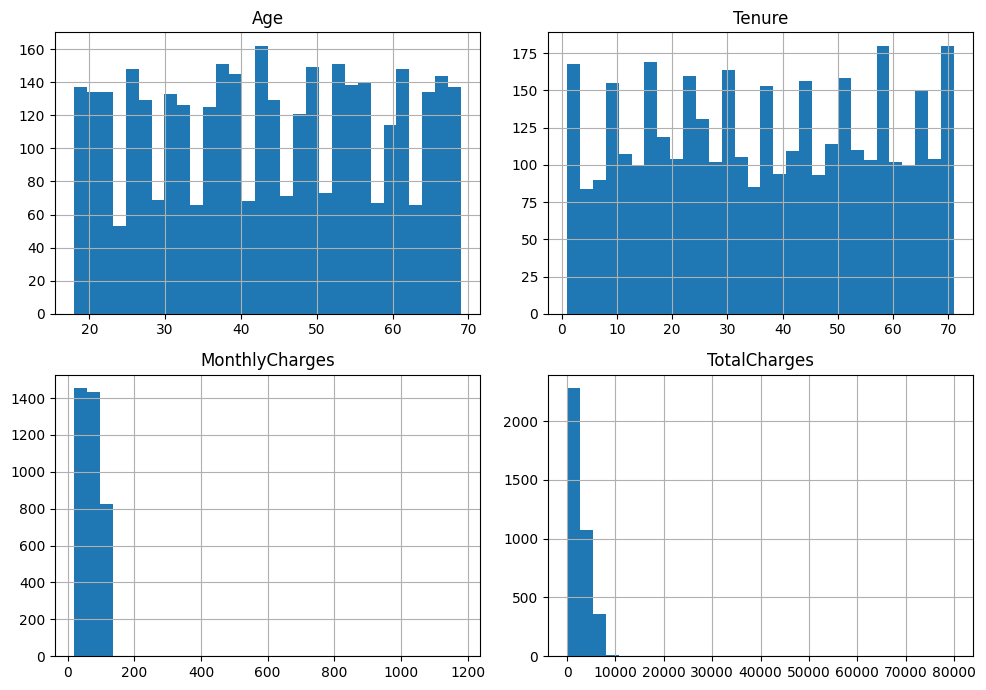

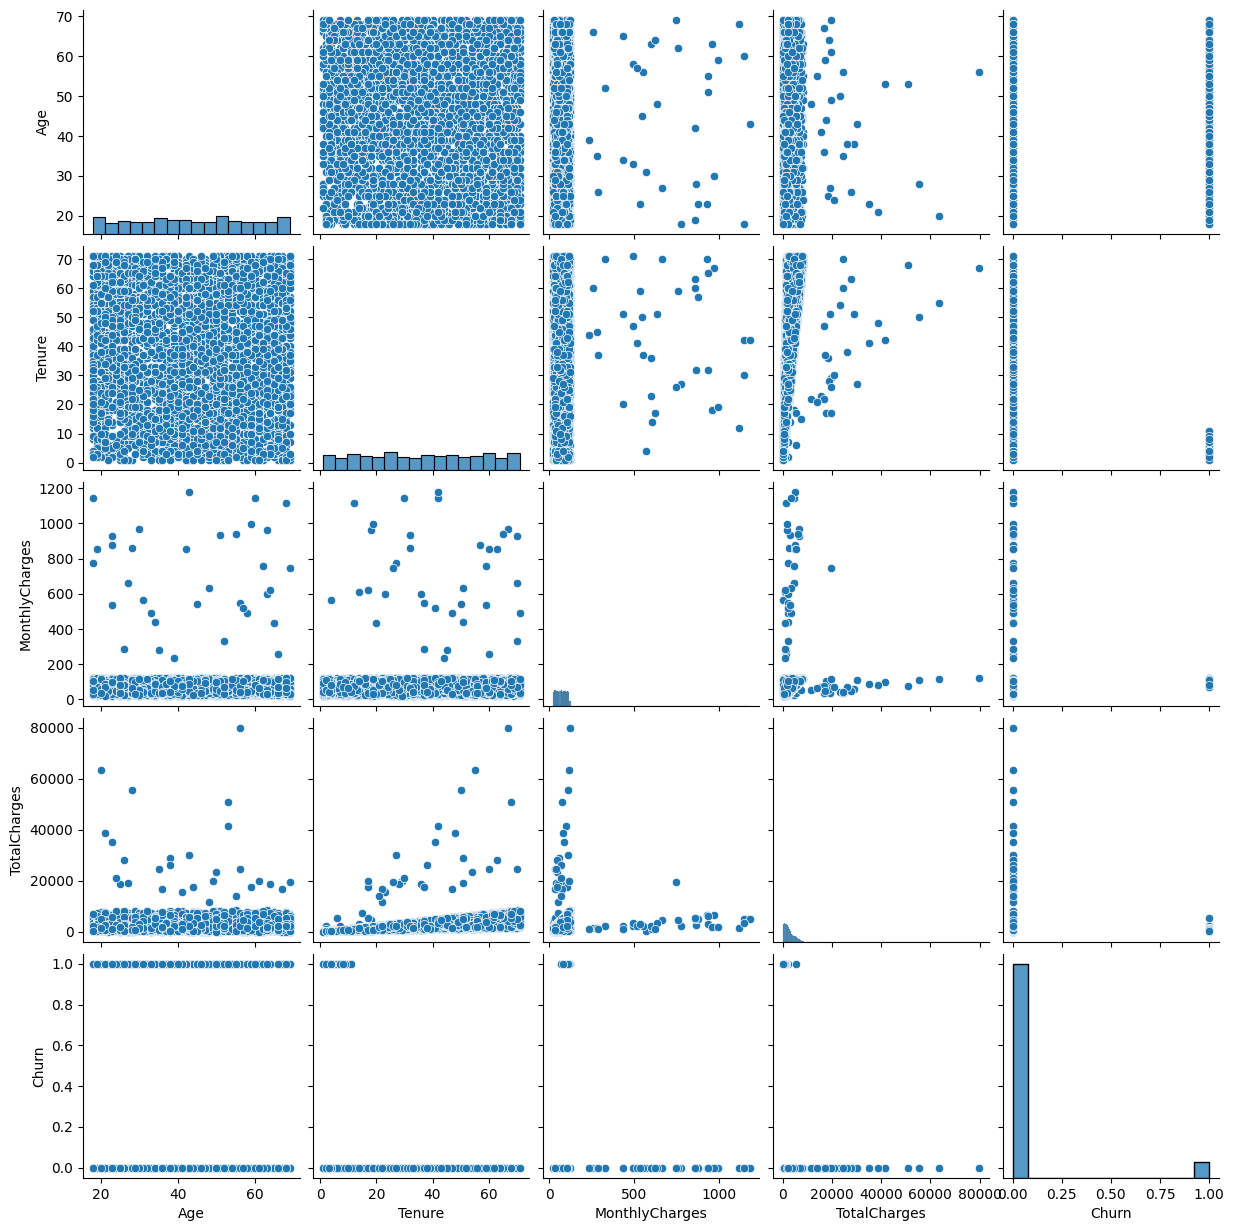

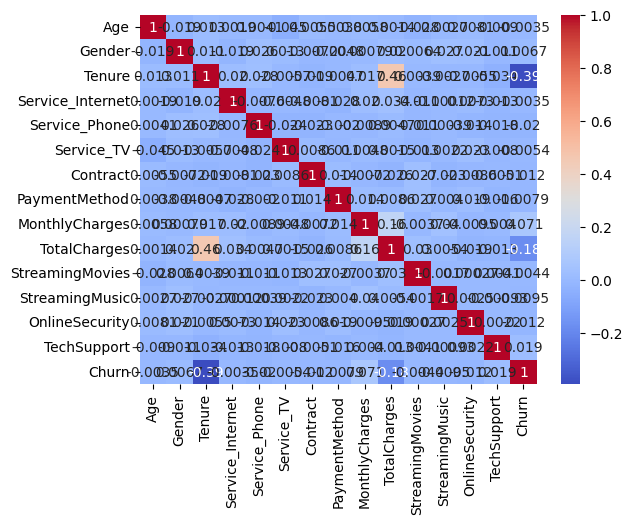

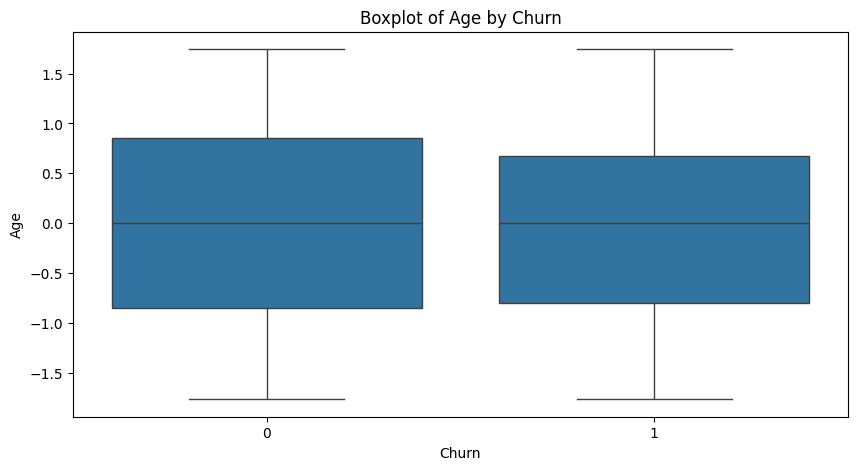

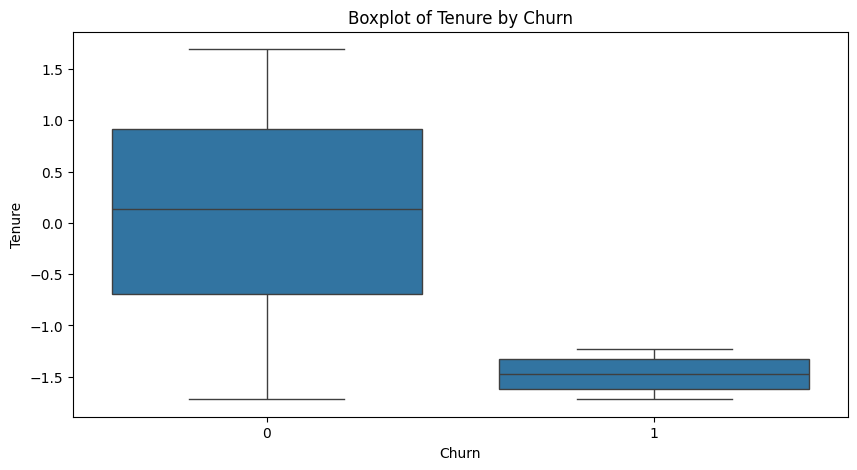

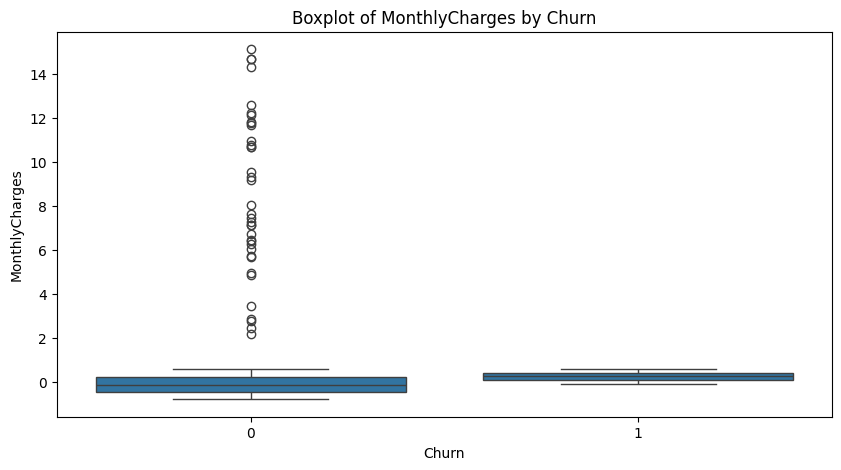

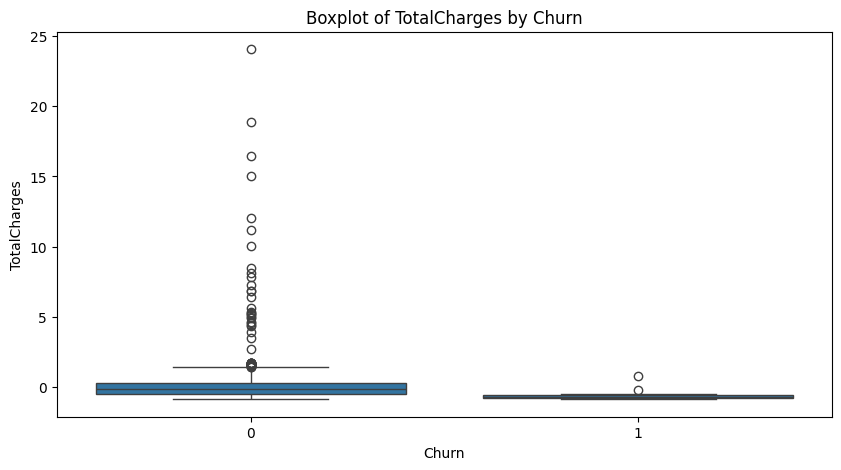

T-test for Tenure: t-statistic=-26.158284214611278, p-value=1.1181117085372203e-138
Logistic Regression: (0.8906666666666667, 0.34574468085106386, 1.0, 0.5138339920948617, 0.9419811320754716)
Random Forest: (0.9982222222222222, 0.9846153846153847, 0.9846153846153847, 0.9846153846153847, 0.9918359941944848)
Gradient Boosting: (0.9991111111111111, 0.9848484848484849, 1.0, 0.9923664122137404, 0.9995283018867924)
Best Random Forest: (0.9982222222222222, 0.9846153846153847, 0.9846153846153847, 0.9846153846153847, 0.9918359941944848)
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


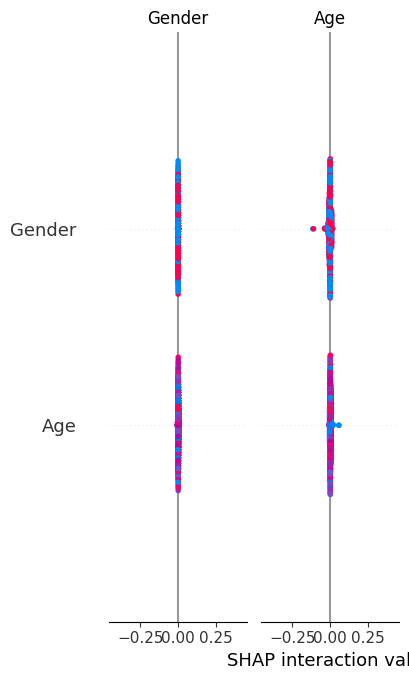

                      feature  importance
2                      Tenure    0.337134
15    TotalCharges_per_Tenure    0.237550
9                TotalCharges    0.186103
8              MonthlyCharges    0.140867
14  MonthlyCharges_per_Tenure    0.091152
0                         Age    0.002519
13                TechSupport    0.000627
7               PaymentMethod    0.000575
1                      Gender    0.000528
4               Service_Phone    0.000520
6                    Contract    0.000506
11             StreamingMusic    0.000502
5                  Service_TV    0.000483
12             OnlineSecurity    0.000413
10            StreamingMovies    0.000284
3            Service_Internet    0.000236


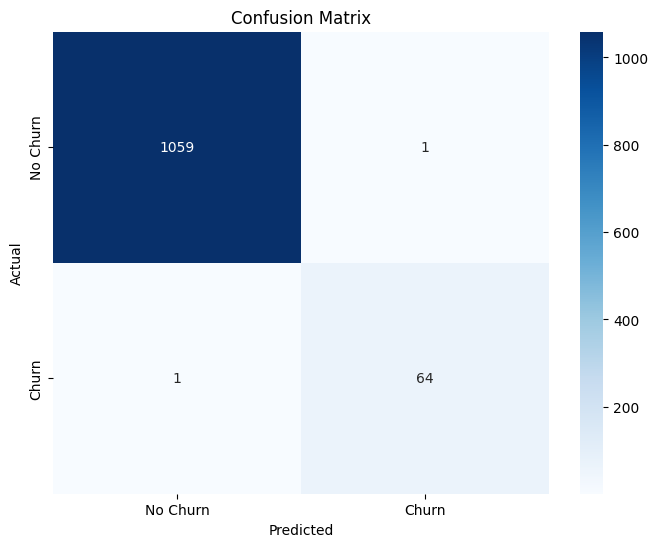

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1060
           1       0.98      0.98      0.98        65

    accuracy                           1.00      1125
   macro avg       0.99      0.99      0.99      1125
weighted avg       1.00      1.00      1.00      1125



In [8]:
# Jupyter Notebook Cell

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import shap
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder


# Load the dataset
df =  pd.read_csv('../Data/dataset_churn.csv')

# Initial exploration
print(df.info())
print(df.describe())
print(df.head())

df = df.drop('Unnamed: 0', axis=1)
df = df.drop('CustomerID', axis=1)

cat_features = ['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV', 'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic', 'OnlineSecurity', 'TechSupport', 'Churn']

# Label encoding for binary categorical feature
label_encoder = LabelEncoder()
for feature in cat_features:
    df[feature] = label_encoder.fit_transform(df[feature])

# Visualize distributions of numerical features
numerical_features = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_features].hist(bins=30, figsize=(10, 7))
plt.tight_layout()
plt.show()

# Visualize relationships between features using scatter plots and correlation matrices
sns.pairplot(df[numerical_features + ['Churn']])
plt.show()

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df.mean(), inplace=True)

# Encode categorical variables
categorical_features = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Normalize numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Split data into training and testing sets
X = df.drop(columns=['Churn'])
y = df['Churn'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Investigate relationships between features and the target variable
for column in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Churn', y=column, data=df)
    plt.title(f'Boxplot of {column} by Churn')
    plt.show()

# Perform hypothesis testing
# Example: t-test on Tenure
churned = df[df['Churn'] == 1]['Tenure']
not_churned = df[df['Churn'] == 0]['Tenure']
t_stat, p_value = stats.ttest_ind(churned, not_churned)
print(f'T-test for Tenure: t-statistic={t_stat}, p-value={p_value}')

# Feature Engineering: Creating interaction terms and ratios
df['MonthlyCharges_per_Tenure'] = df['MonthlyCharges'] / (df['Tenure'] + 1)
df['TotalCharges_per_Tenure'] = df['TotalCharges'] / (df['Tenure'] + 1)

# Update feature set
X = df.drop(columns=['Churn'])
y = df['Churn'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression with balanced class weights
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# Random Forest
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Gradient Boosting
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)

# Evaluate models
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc

print("Logistic Regression:", evaluate_model(y_test, y_pred_log_reg))
print("Random Forest:", evaluate_model(y_test, y_pred_rf))
print("Gradient Boosting:", evaluate_model(y_test, y_pred_gb))

# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=5, scoring='f1')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("Best Random Forest:", evaluate_model(y_test, y_pred_best_rf))
print("Best Parameters:", grid_search_rf.best_params_)

# Model Interpretation using SHAP for Random Forest
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Feature importances from Random Forest
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(feature_importance_df.sort_values(by='importance', ascending=False))

# Confusion Matrix for Best Random Forest
cm = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report for Best Random Forest
print("Classification Report:\n", classification_report(y_test, y_pred_best_rf))

# Prepare presentation slides (pseudo code, actual slide creation would be done in a presentation software)
# Create figures and save them for inclusion in slides
# For example:
# plt.savefig('confusion_matrix.png')

